In [0]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (TensorDataset, DataLoader)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
from torchvision import transforms
from torchvision.datasets import EMNIST
from torch.utils.data.dataset import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

In [0]:
dataset = EMNIST(root = '/', train = True, split = 'letters', transform = transforms.ToTensor(), download = True)

In [0]:
test_dataset = EMNIST(root = '/', train = False, split = 'letters', transform = transforms.ToTensor(), download = True)

In [48]:
input_size = 28*28
output_size = len(dataset.classes)
input_size, output_size

(784, 26)

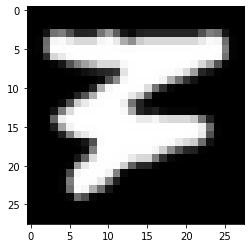

In [49]:
image, label = dataset[0]
plt.imshow(image[0, :, :], cmap = 'gray')

In [50]:
val_size = int(0.2*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(99840, 24960)

In [0]:
batch_size = 128

In [0]:
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)

In [0]:
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)

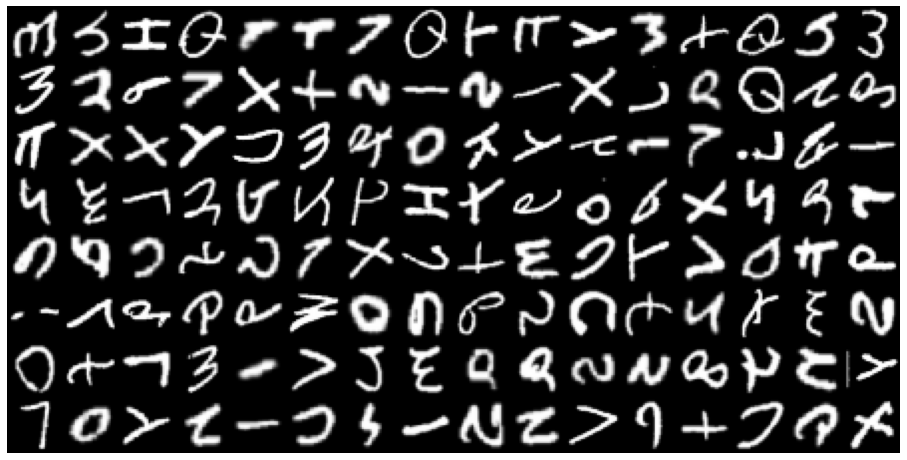

In [55]:
for images, _ in train_loader:
  plt.figure(figsize = (16, 16))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 16, padding = 0).permute(1, 2, 0))
  break

In [56]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [0]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [0]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, self.device)

In [0]:
train_ddl = DeviceDataLoader(train_loader, device)
val_ddl = DeviceDataLoader(val_loader, device)
test_ddl = DeviceDataLoader(test_loader, device)

In [0]:
def find_accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim =1)
  return ((preds == labels).sum()).item() / len(preds)

In [67]:
class EMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 256)
    self.linear2 = nn.Linear(256, 64)
    self.linear3 = nn.Linear(64, output_size)

  def forward(self, images):
    output = self.linear1(images.reshape(-1, 28*28))
    output = F.relu(output)
    output = self.linear2(output)
    output = F.relu(output)
    output = self.linear3(output)
    return output

  def training_batch(self, batch):
    images, labels = batch
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels)
    return loss

  def validation_batch(self, batch):
    images, labels = batch
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels).item()
    accuracy = find_accuracy(outputs, labels)
    return {'val_loss' : loss, 'val_accuracy' : accuracy}

  def validation_end_epoch(self, outputs):
    epoch_loss = sum([x['val_loss'] for x in outputs]) / len(outputs)
    epoch_accuracy = sum([x['val_accuracy'] for x in outputs]) / len(outputs)
    return {'epoch_loss' : epoch_loss, 'epoch_accuracy' : epoch_accuracy}

model = EMNIST()
to_device(model, device)

EMNIST(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=26, bias=True)
)

In [0]:
def validate(model, val_ddl):
  outputs = [model.validation_batch(batch) for batch in val_ddl]
  return model.validation_end_epoch(outputs)

def fit(model, epochs, learning_rate, train_ddl, val_ddl, optimization_func = torch.optim.SGD):
  history = []
  optimizer = optimization_func(model.parameters(), learning_rate)
  for epoch in range(epochs):
    for batch in train_ddl:
      loss = model.training_batch(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = validate(model, val_ddl)
    history.append(result)
    print('Epoch: {}, Validation loss: {:.5f}, Validation accuracy: {:.5f}'.format(epoch, result['epoch_loss'], result['epoch_accuracy']))
  return history

In [69]:
history = [validate(model, val_ddl)]
history

[{'epoch_accuracy': 0.041987179487179484, 'epoch_loss': 3.259159917097825}]

In [70]:
history += fit(model, 5, 0.1, train_ddl, val_ddl)

Epoch: 0, Validation loss: 1.07257, Validation accuracy: 0.70016
Epoch: 1, Validation loss: 0.79710, Validation accuracy: 0.77893
Epoch: 2, Validation loss: 0.67582, Validation accuracy: 0.80789
Epoch: 3, Validation loss: 0.61617, Validation accuracy: 0.82953
Epoch: 4, Validation loss: 0.58144, Validation accuracy: 0.83542


In [71]:
history += fit(model, 5, 0.01, train_ddl, val_ddl)

Epoch: 0, Validation loss: 0.55133, Validation accuracy: 0.84631
Epoch: 1, Validation loss: 0.54680, Validation accuracy: 0.84856
Epoch: 2, Validation loss: 0.54501, Validation accuracy: 0.84868
Epoch: 3, Validation loss: 0.54166, Validation accuracy: 0.84756
Epoch: 4, Validation loss: 0.53994, Validation accuracy: 0.84932


In [72]:
history += fit(model, 5, 0.1, train_ddl, val_ddl)

Epoch: 0, Validation loss: 0.55147, Validation accuracy: 0.84511
Epoch: 1, Validation loss: 0.53113, Validation accuracy: 0.84908
Epoch: 2, Validation loss: 0.51866, Validation accuracy: 0.85697
Epoch: 3, Validation loss: 0.50921, Validation accuracy: 0.85685
Epoch: 4, Validation loss: 0.51532, Validation accuracy: 0.85497


Text(0.5, 1.0, 'Accuracy vs No. of Epochs')

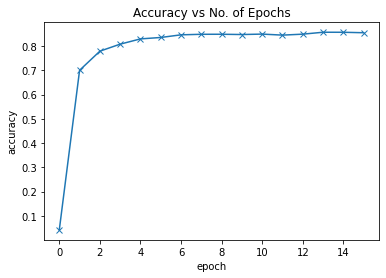

In [76]:
accuracies = [x['epoch_accuracy'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of Epochs')

In [79]:
validate(model, test_ddl)

{'epoch_accuracy': 0.8599980828220859, 'epoch_loss': 0.5141902072298015}